In [3]:
import pandas as pd
PATH = '../data/'
df = pd.read_csv(PATH + 'train.csv')
df.head(2)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.000000,17,4.0,4,650000+
1,13380,austin,"4644 Hoffman Dr, Austin, TX 78749 is a single ...",Single Family,30.199486,-97.859947,0,False,1997,0,6534.0,6.666667,16,3.0,4,350000-450000


# Exploratory Data Analysis (EDA)

In [9]:
import seaborn as sns

In [5]:
df['priceRange'].value_counts(normalize = True)

priceRange
250000-350000    0.2356
350000-450000    0.2301
450000-650000    0.2275
650000+          0.1819
0-250000         0.1249
Name: proportion, dtype: float64

In [6]:
df['homeType'].value_counts(normalize = True)

homeType
Single Family            0.9427
Condo                    0.0333
Townhouse                0.0113
Multiple Occupancy       0.0060
Residential              0.0027
Apartment                0.0019
Mobile / Manufactured    0.0010
MultiFamily              0.0005
Vacant Land              0.0004
Other                    0.0002
Name: proportion, dtype: float64

In [7]:
df['hasSpa'].value_counts(normalize = True)

hasSpa
False    0.9175
True     0.0825
Name: proportion, dtype: float64

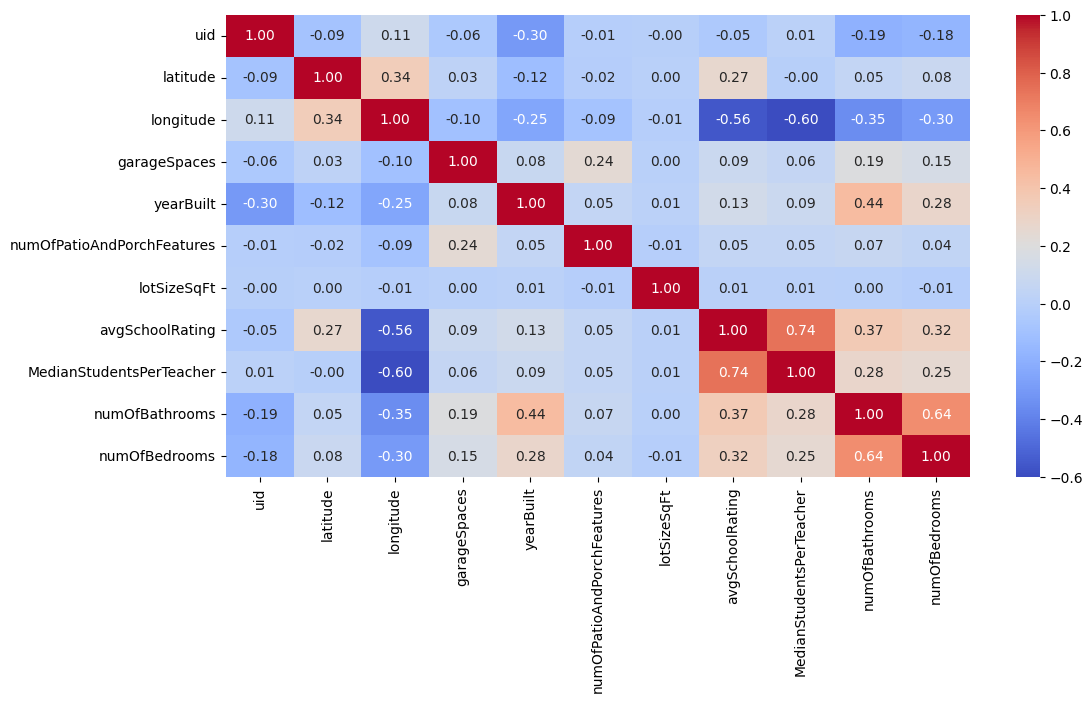

In [10]:
import matplotlib.pyplot as plt 
df_numeric = df.select_dtypes(include =['number'])
corr_matrix = df_numeric.corr() #pearson correlation
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()


# Identify Distributions

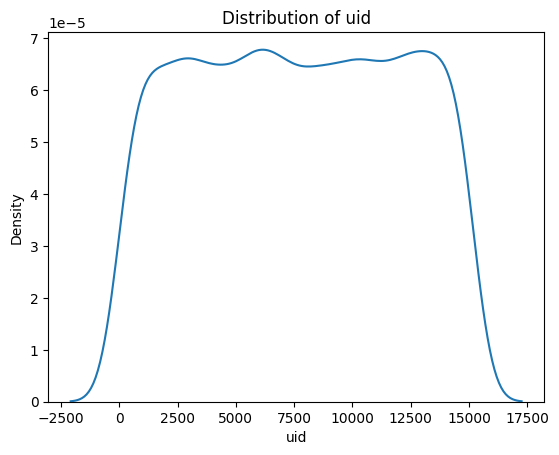

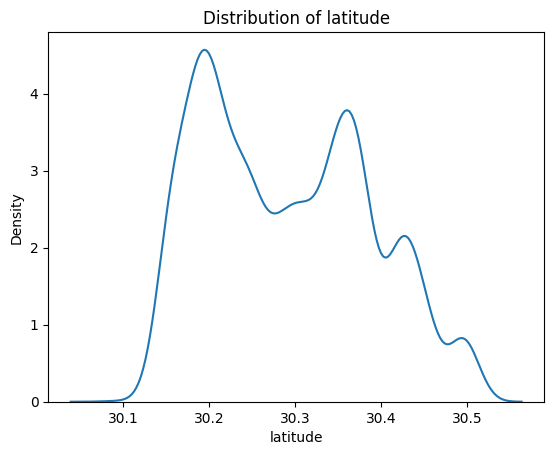

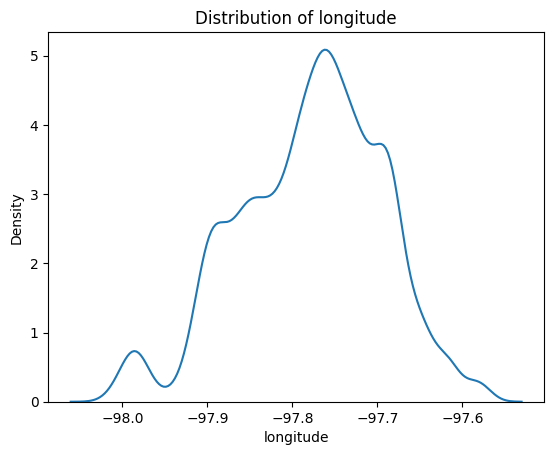

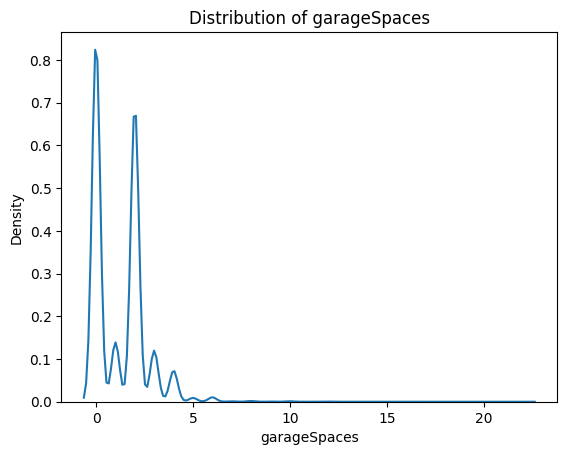

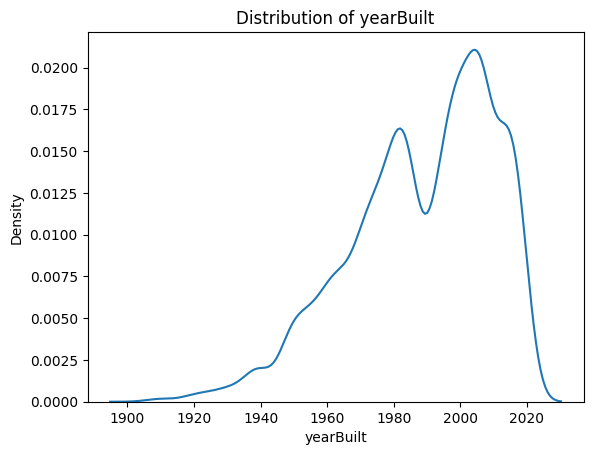

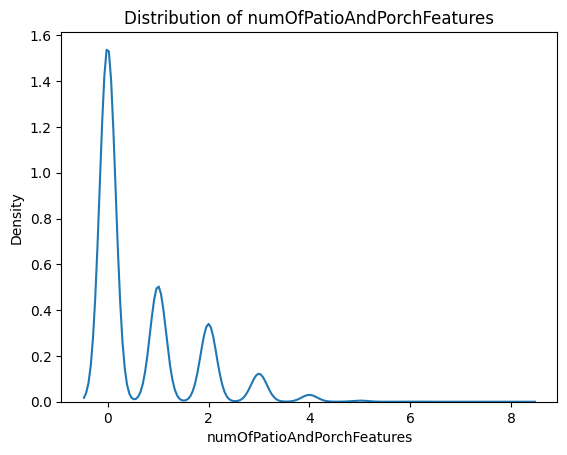

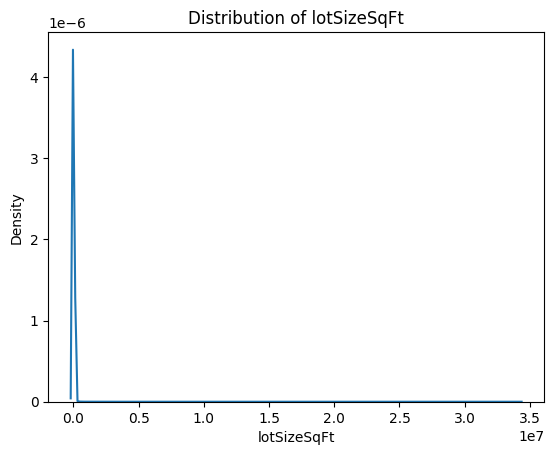

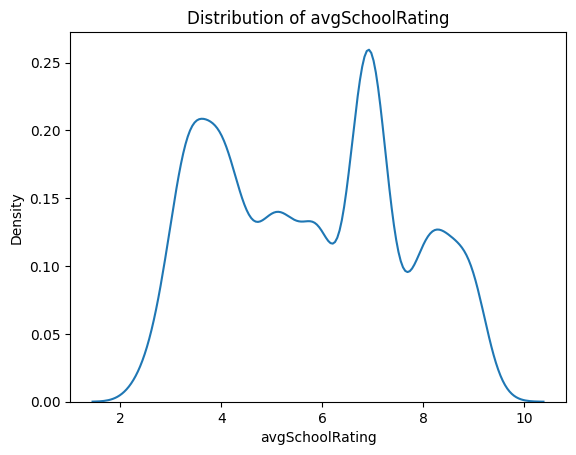

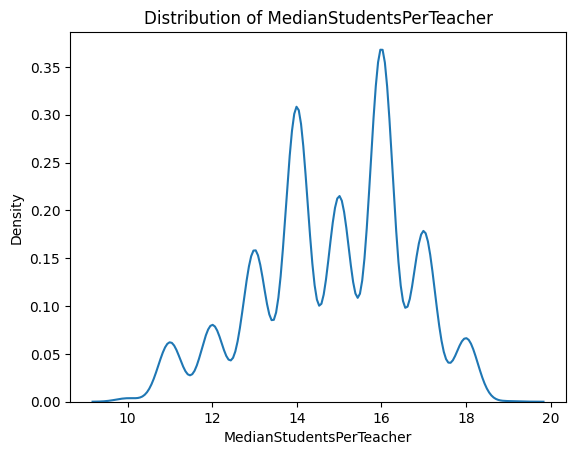

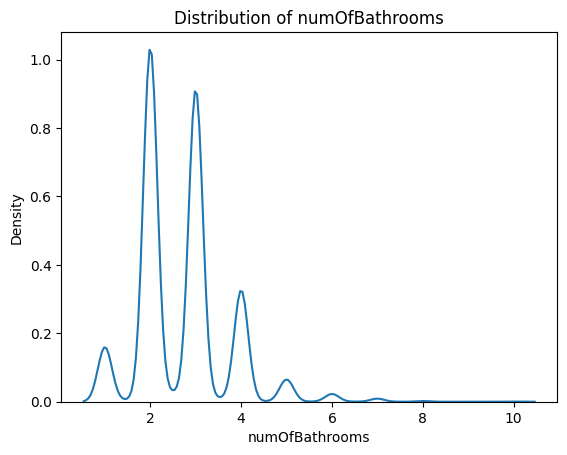

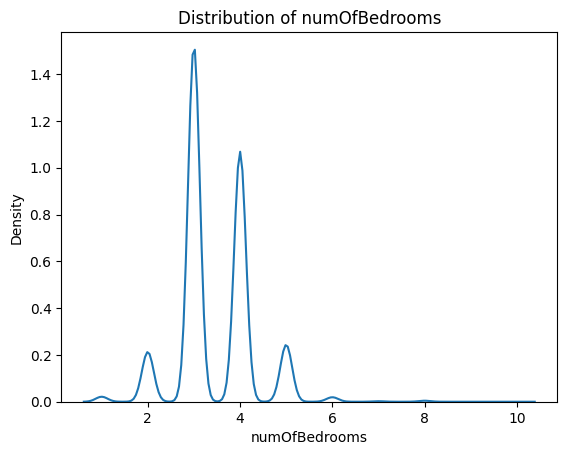

In [12]:
def identify(dataset: pd.DataFrame, feature_list:list):
    for feature in feature_list:
        sns.kdeplot(x = feature, data = dataset)
        plt.title(f'Distribution of {feature}')
        plt.show()
identify(df, df_numeric.columns)

# Data Pre-Processing

In [13]:
df['hasSpa'] = df['hasSpa'].apply(lambda x: 1 if x == True else 0)

In [22]:
def aggregate_year_built(df:pd.DataFrame) -> pd.DataFrame:
    bins = [1900, 1920, 1940, 1960, 1980, 2000,2010, 2021]
    labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2010','2010-2021']
    df['yearBuilt_Labels'] = pd.cut(df['yearBuilt'], bins = bins, labels = labels, include_lowest=True)
    return df 

In [23]:
df['homeType'].unique()

array(['Single Family', 'Multiple Occupancy', 'Condo', 'Apartment',
       'MultiFamily', 'Townhouse', 'Other', 'Residential',
       'Mobile / Manufactured', 'Vacant Land'], dtype=object)

In [24]:
def aggregate_by_home_type(value:str):
    result = ''
    if value in ['Single Family','Townhouse', 'Mobile / Manufactured']:
        result = 'Single Residential'
    elif value in ['Multiple Occupancy', 'Condo', 'Apartment','MultiFamily']:
        result = 'Multi Residential'
    else:
        result = 'Other'
    return result
    

In [25]:
df['homeType_Labels'] = df['homeType'].apply(aggregate_by_home_type)
df = aggregate_year_built(df)

In [26]:
df_year_built = pd.get_dummies(df['yearBuilt_Labels'], prefix = 'year').replace({True: 1, False: 0})
df_home_types = pd.get_dummies(df['homeType_Labels'], prefix = 'home_type').replace({True: 1, False: 0})

/var/folders/4l/xlq2hqg90jl3mj85fjgjkxg40000gr/T/ipykernel_63121/2910853746.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_year_built = pd.get_dummies(df['yearBuilt_Labels'], prefix = 'year').replace({True: 1, False: 0})
/var/folders/4l/xlq2hqg90jl3mj85fjgjkxg40000gr/T/ipykernel_63121/2910853746.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_home_types = pd.get_dummies(df['homeType_Labels'], prefix = 'home_type').replace({True: 1, False: 0})


In [38]:
df_concat = pd.concat([df, df_year_built, df_home_types],axis=1)

# Build de Model

In [39]:
df_concat.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange', 'homeType_Labels',
       'yearBuilt_Labels', 'year_1900-1920', 'year_1920-1940',
       'year_1940-1960', 'year_1960-1980', 'year_1980-2000', 'year_2000-2010',
       'year_2010-2021', 'home_type_Multi Residential', 'home_type_Other',
       'home_type_Single Residential'],
      dtype='object')

In [40]:
SELECT_FEATURES = ['latitude', 'longitude','garageSpaces', 'hasSpa','numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange','year_1900-1920', 'year_1920-1940',
       'year_1940-1960', 'year_1960-1980', 'year_1980-2000', 'year_2000-2010',
       'year_2010-2021', 'home_type_Multi Residential', 'home_type_Other',
       'home_type_Single Residential']
df_select_features = df_concat[SELECT_FEATURES]

In [41]:
X = df_select_features.drop(['priceRange'],axis=1)
y = df_select_features['priceRange']

In [42]:
X

,latitude,longitude,garageSpaces,hasSpa,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,year_1900-1920,year_1920-1940,year_1940-1960,year_1960-1980,year_1980-2000,year_2000-2010,year_2010-2021,home_type_Multi Residential,home_type_Other,home_type_Single Residential
0,30.380089,-97.800621,0,0,0,102366.0,7.000000,17,4.0,4,0,0,0,0,1,0,0,0,0,1
1,30.199486,-97.859947,0,0,0,6534.0,6.666667,16,3.0,4,0,0,0,0,1,0,0,0,0,1
2,30.227398,-97.696083,0,0,0,5619.0,3.333333,11,1.0,2,0,0,1,0,0,0,0,0,0,1
3,30.205469,-97.792351,4,0,0,6416.0,4.000000,14,2.0,4,0,0,0,1,0,0,0,0,0,1
4,30.345106,-97.767426,2,0,0,10759.0,7.000000,16,3.0,5,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30.409927,-97.763390,2,0,3,15246.0,7.000000,17,3.0,3,0,0,0,0,1,0,0,0,0,1
9996,30.206074,-97.779472,0,0,0,6577.0,4.000000,14,2.0,3,0,0,0,1,0,0,0,0,0,1
9997,30.198936,-97.810913,0,0,1,7623.0,4.000000,13,2.0,3,0,0,0,0,1,0,0,0,0,1
9998,30.391880,-97.761292,0,0,2,13939.2,7.000000,17,3.0,3,0,0,0,1,0,0,0,0,0,1


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
def metrics(y_true, y_pred, average = 'weighted'):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average=average),
        'Recall': recall_score(y_true, y_pred, average=average),
        'F1-Score': f1_score(y_true, y_pred, average=average),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred)
    }
    return metrics

In [49]:
y_pred = rfc.predict(X_test)

metrics = metrics(y_test, y_pred)

In [50]:
metrics

{'Accuracy': 0.6095,
 'Precision': 0.613664210851998,
 'Recall': 0.6095,
 'F1-Score': 0.6098565141746748,
 'confusion_matrix': array([[136,  86,  32,   5,   1],
        [ 52, 286, 106,  22,   6],
        [  8, 113, 250,  85,   6],
        [  2,  20,  96, 277,  66],
        [  0,   3,   4,  68, 270]]),
 'classification_report': '               precision    recall  f1-score   support\n\n     0-250000       0.69      0.52      0.59       260\n250000-350000       0.56      0.61      0.58       472\n350000-450000       0.51      0.54      0.53       462\n450000-650000       0.61      0.60      0.60       461\n      650000+       0.77      0.78      0.78       345\n\n     accuracy                           0.61      2000\n    macro avg       0.63      0.61      0.62      2000\n weighted avg       0.61      0.61      0.61      2000\n'}

In [52]:
print(metrics['classification_report'])

               precision    recall  f1-score   support

     0-250000       0.69      0.52      0.59       260
250000-350000       0.56      0.61      0.58       472
350000-450000       0.51      0.54      0.53       462
450000-650000       0.61      0.60      0.60       461
      650000+       0.77      0.78      0.78       345

     accuracy                           0.61      2000
    macro avg       0.63      0.61      0.62      2000
 weighted avg       0.61      0.61      0.61      2000



In [54]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np 
param_dist = {
    'n_estimators':np.arange(50,300,50),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2,5],
    'max_features':['sqrt', 'log', None]
}

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rfc,
    param_distributions= param_dist,
    n_iter = 20,
    scoring='accuracy',
    cv = 5,
    verbose = 2, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=log, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=log, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=log, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=log, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=log, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=log, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=log, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=log, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=log, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=l

/Users/thiago.montenegro/fullstack_teste/fullstack/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/thiago.montenegro/fullstack_teste/fullstack/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thiago.montenegro/fullstack_teste/fullstack/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/thiago.montenegro/fullstack_teste/fullstack/lib/python3.10/

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log', None],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   random_state=42, scoring='accuracy', verbose=2)

In [58]:
print('Best Parameters', random_search.best_estimator_)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
metrics_best_rf = metrics(y_test, y_pred)

Best Parameters RandomForestClassifier(min_samples_split=5, n_estimators=np.int64(250),
                       n_jobs=-1, random_state=42)


In [59]:
metrics_best_rf

{'Accuracy': 0.621,
 'Precision': 0.6278609624278562,
 'Recall': 0.621,
 'F1-Score': 0.62052668788111,
 'confusion_matrix': array([[126,  91,  36,   5,   2],
        [ 41, 298, 103,  24,   6],
        [  3, 116, 251,  86,   6],
        [  1,  17,  91, 288,  64],
        [  0,   3,   5,  58, 279]]),
 'classification_report': '               precision    recall  f1-score   support\n\n     0-250000       0.74      0.48      0.58       260\n250000-350000       0.57      0.63      0.60       472\n350000-450000       0.52      0.54      0.53       462\n450000-650000       0.62      0.62      0.62       461\n      650000+       0.78      0.81      0.79       345\n\n     accuracy                           0.62      2000\n    macro avg       0.65      0.62      0.63      2000\n weighted avg       0.63      0.62      0.62      2000\n'}

In [65]:
X_test.sample(1)

,latitude,longitude,garageSpaces,hasSpa,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,year_1900-1920,year_1920-1940,year_1940-1960,year_1960-1980,year_1980-2000,year_2000-2010,year_2010-2021,home_type_Multi Residential,home_type_Other,home_type_Single Residential
5741,30.434021,-97.796356,0,0,2,14374.8,8.666667,16,2.0,3,0,0,0,0,1,0,0,0,0,1


In [64]:
df_select_features.columns

Index(['latitude', 'longitude', 'garageSpaces', 'hasSpa',
       'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'avgSchoolRating',
       'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms',
       'priceRange', 'year_1900-1920', 'year_1920-1940', 'year_1940-1960',
       'year_1960-1980', 'year_1980-2000', 'year_2000-2010', 'year_2010-2021',
       'home_type_Multi Residential', 'home_type_Other',
       'home_type_Single Residential'],
      dtype='object')

In [61]:
print(metrics_best_rf['classification_report'])

               precision    recall  f1-score   support

     0-250000       0.74      0.48      0.58       260
250000-350000       0.57      0.63      0.60       472
350000-450000       0.52      0.54      0.53       462
450000-650000       0.62      0.62      0.62       461
      650000+       0.78      0.81      0.79       345

     accuracy                           0.62      2000
    macro avg       0.65      0.62      0.63      2000
 weighted avg       0.63      0.62      0.62      2000



In [62]:
import pickle 
with open('model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)